# Get data

In [26]:
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import glob
from pathlib import Path
import seaborn as sns

kaplan_plots = True
cox_analysis = False

date_time_str = '20230622_002127'
data_path = Path(os.getcwd())

if kaplan_plots:
    kmf = KaplanMeierFitter()

    csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))

    if not os.path.exists(f"imgs/{date_time_str}"):
        os.makedirs(f"imgs/{date_time_str}")

    # Group runs by experiment
    grouped_files = {}
    for file in csv_files:
        file_name = os.path.basename(file)
        name_without_suffix = file_name.rsplit("-", 1)[0]
        suffix = file_name.rsplit("-", 1)[1]
        group_key = name_without_suffix

        if group_key not in grouped_files:
            grouped_files[group_key] = []

        grouped_files[group_key].append(file)


    kmfs = {}
    cphs = {}

    # Print the grouped file paths
    for group_key, files in grouped_files.items():
        fig = plt.figure()
        # For computing the mean
        surv_func_ci = pd.DataFrame()
        amt_of_runs = len(files)
        
        mean_survival_plots = pd.DataFrame(columns=list("TE"))
        CPH_data = pd.DataFrame()

        for i, file_path in enumerate(files):
            data_for_CPH = pd.read_csv(file_path)
            
            datakf = data_for_CPH[list('TE')]
            
            mean_survival_plots = pd.concat([mean_survival_plots, datakf])
            CPH_data = pd.concat([CPH_data, data_for_CPH])

        kmf = KaplanMeierFitter(label=group_key)
        cphs[group_key] = CPH_data

        kmfs[group_key] = kmf.fit(mean_survival_plots["T"], mean_survival_plots['E']) # Deze line geeft die warnings, maar kon het niet oplossen nog
        kmf.plot(label='Mean')

        plt.suptitle("Kaplan-Meier survival graph", fontsize=18)
        plt.title(group_key, fontsize=10)
        plt.xlabel("Time steps")
        plt.ylabel("Survival probability")
        plt.legend()

        plt.savefig(f"imgs/{date_time_str}/km-{group_key}.png")
        plt.close()

In [27]:
# All combinations image A (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [50, 100] # [50, 100, 200, 300]
dists = ['RandomGrid', 'Sides', 'Uniform']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)

            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (A)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-A.pdf")
plt.close()


# All combinations image B (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [200, 300] # [50, 100, 200, 300]
dists = ['RandomGrid', 'Sides', 'Uniform']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)
            
            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (B)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-B.pdf")
plt.close()

C:\Users\guido\AppData\Local\Temp\ipykernel_20892\124553405.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)
C:\Users\guido\AppData\Local\Temp\ipykernel_20892\124553405.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)


# CPH for BLobs

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
         T    E  Trade_random  Trade_search  Trade_market
0    230.0  1.0             0             0             0
1   1000.0  0.0             0             0             0
2   1000.0  0.0             0             0             0
3   1000.0  0.0             0             0             0
4    517.0  1.0             0             0             0
..     ...  ...           ...           ...           ...
45  1000.0  0.0             0             0             1
46   579.0  1.0             0             0             1
47   251.0  1.0             0             0             1
48   333.0  1.0             0             0             1
49   274.0  1.0             0             0             1

[1000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1000 total observations, 681 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Trade_market km             41.61 <0.005     33.07
             rank           41.96 <0.005     33.32
Trade_random km              3.63   0.06      4.14
             rank            3.59   0.06      4.10
Trade_search km              0.60   0.44      1.19
             rank            0.61   0.43      1.20



1. Variable 'Trade_market' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_market', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 1000 total observations, 681 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 319
   partial log-likelihood = -1986.01
         time fit was run = 2023-06-22 10:44:15 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.23       0.79       0.14            -0.50             0.04                 0.60                 1.04
Trade_search  -1.14       0.32       0.16            -1.46            -0.82                 0.23                 0.44
Trade_market   1.41       4.10       0.11             1.18             1.63                 3.27                 5.13

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -1.67   0.09       3.41
Trade_search     0.00 -7.04 <0.005      38.93
Trade_market     0.00 12.28 <0.005     112.73
---
Concordance = 0.50
Partial AIC = 3978.03
log-likelihood ratio test = 320.78 on 3 df
-log2(p) of ll-ratio test = 227.55

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.231947   0.792988  0.138660       -0.503716        0.039822   
Trade_search -1.140122   0.319780  0.161929       -1.457497       -0.822748   
Trade_market  1.409767   4.095002  0.114803        1.184758        1.634777   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
Trade_random             0.604281             1.040626     0.0  -1.672769   
Trade_search             0.232818             0.439223     0.0  -7.040886   
Trade_market             3.269894             5.128315     0.0  12.279880   

                         p    -log2(p)  
covariate                               
Trade_random  9.437270e-02    3.405487  
Trade_search  1.910218e-12   38.929400  
Trade_market  1.161706e-34  112.729

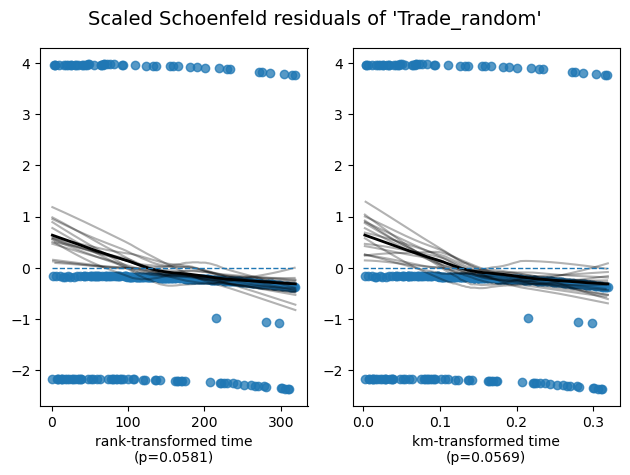

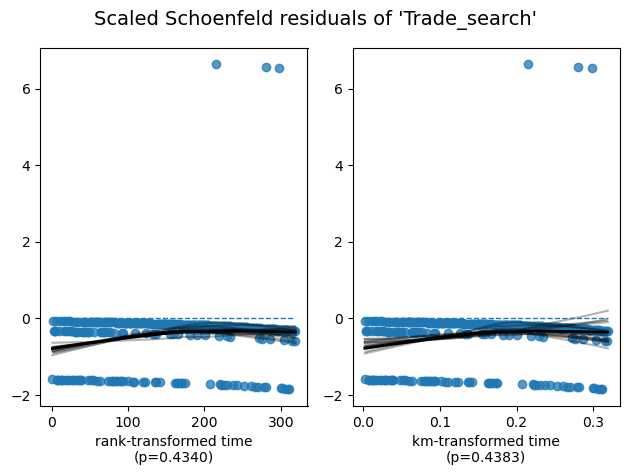

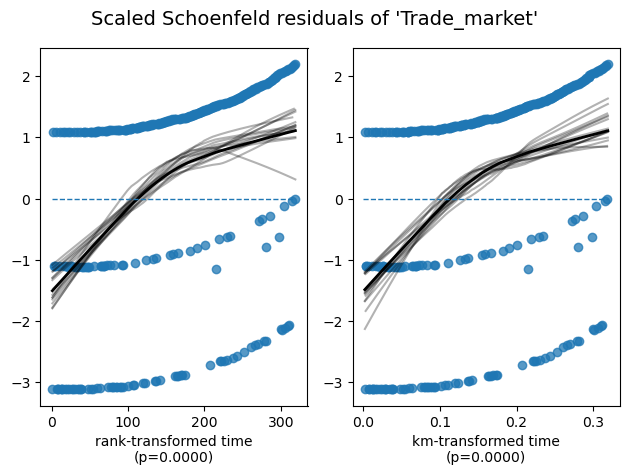

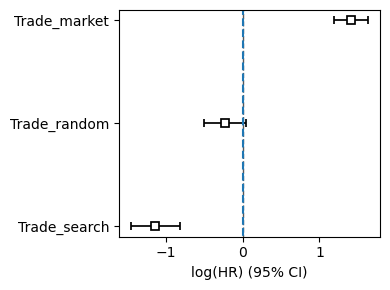

In [28]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs['Baseline-no_trade-RandomGrid-50-1'],
                             cphs['Baseline-random-RandomGrid-50-1'],
                             cphs['Baseline-pathfind_neighbor-RandomGrid-50-1'],
                             cphs['Market-pathfind_market-RandomGrid-50-1'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-randomblobs-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-randomblobs-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.savefig(f"imgs/{date_time_str}/results_blobs.png", dpi=700, transparent=True)
    plt.show()

# CPH for Sides

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
        T    E  Trade_random  Trade_search  Trade_market
0   135.0  1.0             0             0             0
1   211.0  1.0             0             0             0
2   191.0  1.0             0             0             0
3   122.0  1.0             0             0             0
4   142.0  1.0             0             0             0
..    ...  ...           ...           ...           ...
45  195.0  1.0             0             0             1
46  180.0  1.0             0             0             1
47  173.0  1.0             0             0             1
48  158.0  1.0             0             0             1
49  168.0  1.0             0             0             1

[1000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a

<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5856.14
         time fit was run = 2023-06-22 11:01:21 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random   0.12       1.13       0.08            -0.04             0.28                 0.96                 1.32
Trade_search  -0.66       0.52       0.08            -0.83            -0.49                 0.44                 0.61
Trade_market  -0.56       0.57       0.08            -0.72            -0.39                 0.49                 0.68

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00  1.42   0.16       2.69
Trade_search     0.00 -7.76 <0.005      46.76
Trade_market     0.00 -6.62 <0.005      34.73
---
Concordance = 0.50
Partial AIC = 11718.27
log-likelihood ratio test = 111.98 on 3 df
-log2(p) of ll-ratio test = 77.69

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random  0.117840   1.125064  0.082928       -0.044696        0.280375   
Trade_search -0.659468   0.517126  0.084963       -0.825993       -0.492943   
Trade_market -0.555711   0.573664  0.083898       -0.720148       -0.391274   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.956288             1.323626     0.0  1.420992   
Trade_search             0.437800             0.610826     0.0 -7.761805   
Trade_market             0.486680             0.676195     0.0 -6.623654   

                         p   -log2(p)  
covariate                              
Trade_random  1.553192e-01   2.686692  
Trade_search  8.372900e-15  46.763194  
Trade_market  3.504258e-11  34.732100  


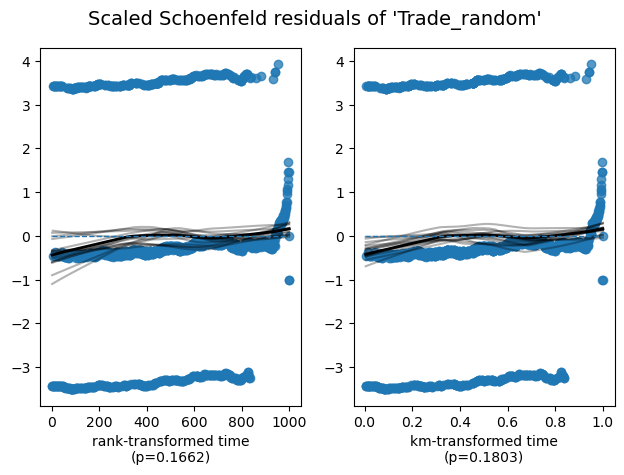

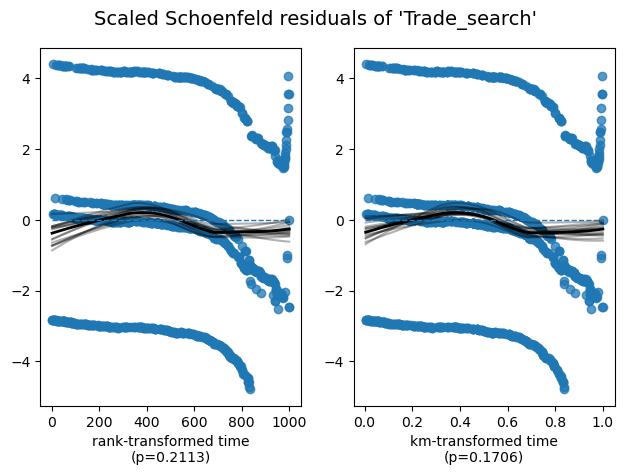

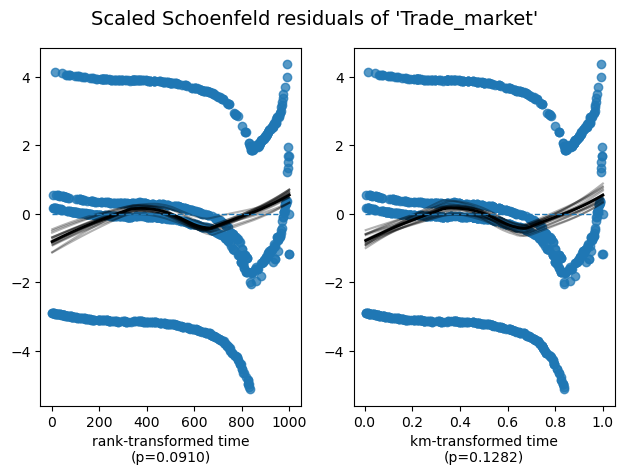

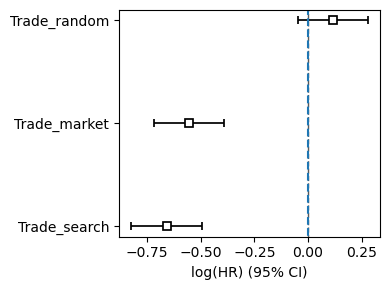

In [34]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-50-0.8'],
                             cphs[f'Baseline-random-Sides-50-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-50-0.8'],
                             cphs[f'Market-pathfind_market-Sides-50-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.savefig(f"imgs/{date_time_str}/results_sides.png", dpi=700, transparent=True)
    plt.show()

# CPH Sides threshold of significance market (varying nr agents)

In [30]:
# cox_analysis = True

# nagentsss = [50, 100, 200, 300]

# plt.figure(figsize=(16,3))

# for i, n_agents in enumerate(nagentsss):
#     if i > 0:
#         ax = plt.subplot(1, 4, i+1, sharey=ax)
#     else:
#         ax = plt.subplot(1, 4, i+1)
#     combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-{n_agents}-0.8'],
#                              cphs[f'Baseline-random-Sides-{n_agents}-0.8'],
#                              cphs[f'Baseline-pathfind_neighbor-Sides-{n_agents}-0.8'],
#                              cphs[f'Market-pathfind_market-Sides-{n_agents}-0.8'],
#     ])
    
#     le = LabelEncoder()
#     print(combined_df.keys())

#     def update_trades(row):
#         if row["Agent_type"] == 'no_trade':
#             row["Trade_random"] = 0
#             row["Trade_search"] = 0
#             row["Trade_market"] = 0
#         elif row["Agent_type"] == 'random':
#             row["Trade_random"] = 1
#             row["Trade_search"] = 0
#             row["Trade_market"] = 0
#         elif row["Agent_type"] == 'pathfind_neighbor':
#             row["Trade_random"] = 0
#             row["Trade_search"] = 1
#             row["Trade_market"] = 0
#         elif row["Agent_type"] == 'pathfind_market':
#             row["Trade_random"] = 0
#             row["Trade_search"] = 0
#             row["Trade_market"] = 1
#         return row

#     # Assuming you have a DataFrame named combined_df
#     combined_df = combined_df.apply(update_trades, axis=1)
    
#     combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
#     combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
#     combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
#     combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

#     combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-data.csv")

#     cph = CoxPHFitter(penalizer=0.1)
#     cph.fit(combined_df, "T", "E", show_progress=False)
#     cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

#     cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-results.csv")
#     cph.print_summary()

#     cph.plot()
#     plt.title(f'Nr agents = {n_agents}')
#     plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
#     plt.tight_layout()
#     plt.suptitle('Comparison of significance on Sides. prob. = 0.8')
    
# plt.show()

# CPH for Uniform

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
          T    E  Trade_random  Trade_search  Trade_market
0     422.0  1.0             0             0             0
1     447.0  1.0             0             0             0
2     249.0  1.0             0             0             0
3    1000.0  0.0             0             0             0
4     521.0  1.0             0             0             0
..      ...  ...           ...           ...           ...
295   311.0  1.0             0             0             1
296   256.0  1.0             0             0             1
297   351.0  1.0             0             0             1
298   516.0  1.0             0             0             1
299   348.0  1.0             0             0             1

[6000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_thre

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6000 total observations, 1398 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Trade_market km              1.43   0.23      2.11
             rank            2.12   0.15      2.78
Trade_random km              3.20   0.07      3.76
             rank            3.36   0.07      3.90
Trade_search km              8.96 <0.005      8.51
             rank            9.90 <0.005      9.24



1. Variable 'Trade_search' failed the non-proportional test: p-value is 0.0017.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_search', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 6000 total observations, 1398 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 4602
   partial log-likelihood = -37468.79
         time fit was run = 2023-06-22 11:05:34 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.01       0.99       0.04            -0.08             0.06                 0.92                 1.06
Trade_search   0.01       1.01       0.04            -0.06             0.09                 0.94                 1.09
Trade_market   0.05       1.06       0.04            -0.02             0.13                 0.98                 1.13

               cmp to     z    p   -log2(p)
covariate                                  
Trade_random     0.00 -0.28 0.78       0.36
Trade_search     0.00  0.35 0.72       0.47
Trade_market     0.00  1.48 0.14       2.86
---
Concordance = 0.50
Partial AIC = 74943.58
log-likelihood ratio test = 3.19 on 3 df
-log2(p) of ll-ratio test = 1.46

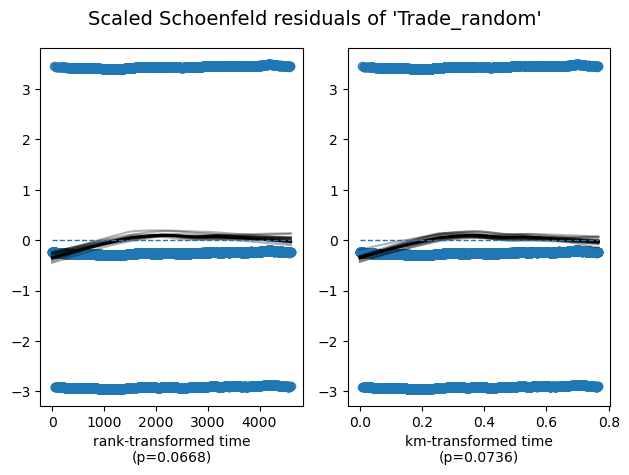

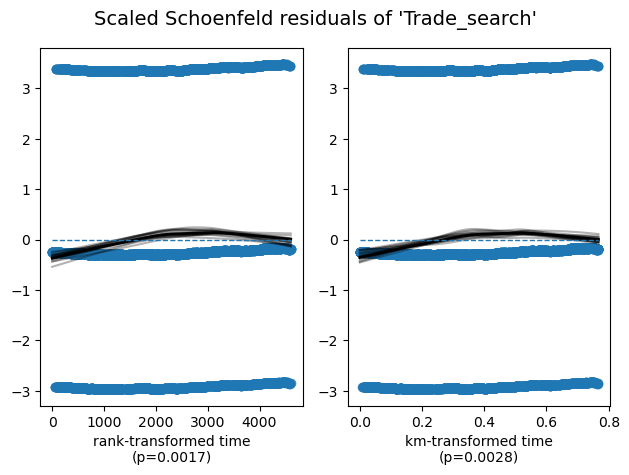

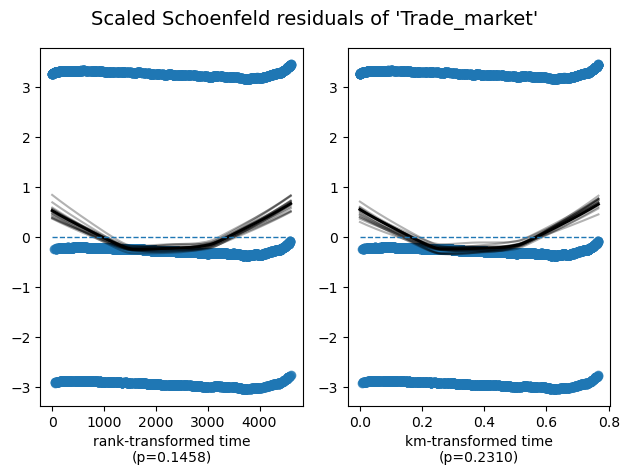

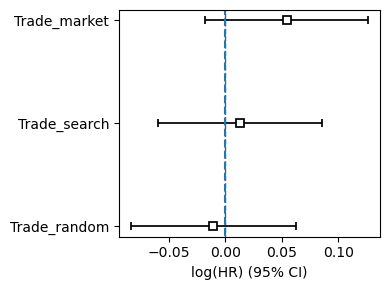

In [35]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Uniform-300-0.8'],
                             cphs[f'Baseline-random-Uniform-300-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Uniform-300-0.8'],
                             cphs[f'Market-pathfind_market-Uniform-300-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)


    cph.print_summary()
    cph_df = cph.summary
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.savefig(f"imgs/{date_time_str}/results_uniform.png", dpi=700, transparent=True)
    plt.show()

# CPH for all data

In [51]:
cox_analysis = True

if cox_analysis:
    # Analysis
    def concatAllRuns(data_path: Path):
        csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))
        combined_df = pd.concat([pd.read_csv(f) for f in csv_files])
        return combined_df
    
    date_time_str = '20230622_002127'
    data_path = Path(os.getcwd())
    combined_df = concatAllRuns(data_path)
    print(combined_df)
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print(combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-results-all.csv")

         T    E  Scenario       Agent_type Distribution  Num_agents  Trading  \
0    538.0  1.0  Baseline         no_trade   RandomGrid         100    False   
1    327.0  1.0  Baseline         no_trade   RandomGrid         100    False   
2   1000.0  0.0  Baseline         no_trade   RandomGrid         100    False   
3    643.0  1.0  Baseline         no_trade   RandomGrid         100    False   
4    121.0  1.0  Baseline         no_trade   RandomGrid         100    False   
..     ...  ...       ...              ...          ...         ...      ...   
45  1000.0  0.0    Market  pathfind_market      Uniform          50     True   
46  1000.0  0.0    Market  pathfind_market      Uniform          50     True   
47  1000.0  0.0    Market  pathfind_market      Uniform          50     True   
48  1000.0  0.0    Market  pathfind_market      Uniform          50     True   
49  1000.0  0.0    Market  pathfind_market      Uniform          50     True   

    Move_prob  Run_number  
0         0

<lifelines.CoxPHFitter: fitted with 117000 total observations, 24023 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 117000
number of events observed = 92977
   partial log-likelihood = -1019127.33
         time fit was run = 2023-06-22 11:52:51 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Distribution  -0.33       0.72       0.00            -0.34            -0.32                 0.72                 0.72
Num_agents     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Move_prob     -0.41       0.66       0.02            -0.44            -0.38                 0.64                 0.68
Trade_random  -0.17       0.84       0.01            -0.19            -0.16                 0.83                 0.85
Trade_search  -0.19       0.82       0.01            -0.21            -0.18                 0.81                 0.84
Trade_market   0.03       1.03       0.01             0.01             0.04                 1.01                 1.04

               cmp to      z      p   -log2(p)
covariate                                     
Distribution     0.00 -97.20 <0.005        inf
Num_agents       0.00 106.87 <0.005        inf
Move_prob        0.00 -27.43 <0.005     547.97
Trade_random     0.00 -20.75 <0.005     315.14
Trade_search     0.00 -23.31 <0.005     396.68
Trade_market     0.00   3.20 <0.005       9.53
---
Concordance = 0.50
Partial AIC = 2038266.65
log-likelihood ratio test = 21927.56 on 6 df
-log2(p) of ll-ratio test = inf

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Distribution -0.328796   0.719790  0.003383       -0.335426       -0.322166   
Num_agents    0.004100   1.004109  0.000038        0.004025        0.004176   
Move_prob    -0.413856   0.661096  0.015086       -0.443424       -0.384288   
Trade_random -0.173266   0.840914  0.008352       -0.189636       -0.156896   
Trade_search -0.193821   0.823805  0.008316       -0.210121       -0.177521   
Trade_market  0.026245   1.026592  0.008189        0.010194        0.042296   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to           z  \
covariate                                                                    
Distribution             0.715034             0.724578     0.0  -97.198383   
Num_agents               1.004033             1.004184     0.0  106.869422   
Move_prob                0.641835   

In [52]:
cph.check_assumptions(combined_df.reset_index(drop=True))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 117000 total observations, 24023 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Distribution km             87.46 <0.005     66.65
             rank           85.14 <0.005     64.96
Move_prob    km             18.19 <0.005     15.61
             rank           18.63 <0.005     15.94
Num_agents   km           4602.38 <0.005       inf
             rank         4604.60 <0.005       inf
Trade_market km           2354.68 <0.005       inf
             rank         2426.20 <0.005       inf
Trade_random km            138.97 <0.005    104.14
             rank          149.96 <0.005    112.13
Trade_search km            843.80 <0.005    613.86
             rank          855.50 <0.005    622.31



1. Variable 'Distribution' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Distribution', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'Num_agents' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 4), you can include `strata=['Num_agents', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'Move_prob' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Move_prob', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable 'Trade_random' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_random', ...]` in the
call in `.fit`. See documentation in link [E] below.

5. Variable 'Trade_search' failed the non-proportional test: p-v

[]

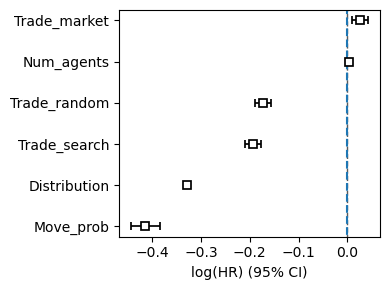

In [53]:
plt.figure(figsize=(4, 3))
cph.plot()
plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
plt.tight_layout()
plt.savefig(f"imgs/{date_time_str}/results_analysis_total.png", dpi=700, transparent=True)
plt.show()